In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as anim

from constants import SimConstants

In [2]:
framerate = 15
writer = anim.PillowWriter(fps=framerate)
save_gifs = False

In [3]:
def get_time_step(i_frame: int, frame_rate: int, time_inc: float) -> int:
    """Get the time step corresponding to actual time passed of simulation.

    Example:
        50 fps -> 0.02s per frame
        0.01 time_inc -> 2 time steps per frame
        3 frames -> 6 time_steps

    Args:
        i_frame: The frame currently being rendered:
        frame_rate: Number of frames rendered per second.
        time_inc: The time passed between time steps.
    """
    return int((i_frame / frame_rate) / time_inc)

In [4]:
i_px = 0
i_py = 1
i_vx = 2
i_vy = 3
i_fx = 4
i_fy = 5
i_pr = 6
i_ps = 7

In [5]:
def read_data(name='n=500,w=10,v=7.5'):
    sconst = SimConstants.from_file(f"./data/const_{name}.json")
    data_csv = pd.read_csv(f"./data/hist_{name}.csv")
    data_arr = data_csv.to_numpy()
    data = data_arr.reshape(sconst.n_time_steps, -1, *data_arr.shape[1:])
    
    return data, sconst

In [6]:
data, sconst = read_data(name='n=300,w=15,v=5')
print(data.shape)

(1000, 300, 8)


In [7]:
%matplotlib inline

avg_densities = np.zeros(sconst.n_time_steps)
allign_coefs = np.zeros(sconst.n_time_steps)

for t in range(sconst.n_time_steps):
    positions = data[t, :, i_px:i_py+1]
    velocities = data[t, :, i_vx:i_vy+1]
    forces = data[t, :, i_fx:i_fy+1]
    pressures = data[t, :, i_pr]
    person_state = data[t, :, i_ps]

    velocities[person_state > 0] = 0
    
    counts = np.zeros(sconst.n_individuals)
    
    mean_velocity = np.linalg.norm(np.mean(velocities, axis=0))+0.000000001
    sum_velocity = np.sum(velocities/sconst.v_max, axis=0)
    allign_coefs[t] = np.linalg.norm(sum_velocity)
    
    for i in range(sconst.n_individuals):
        circle_rad = 1
        circle_area = circle_rad*np.pi*np.pi
        distances = np.linalg.norm(positions[i] - positions, axis=1)
        counts[i] = np.sum(distances < circle_rad)

    avg_densities[t] = np.mean(counts)/circle_area
    
allign_coefs /= sconst.n_individuals
time_steps = np.arange(sconst.n_time_steps)
        

Text(0.5, 0, 'Time [s]')

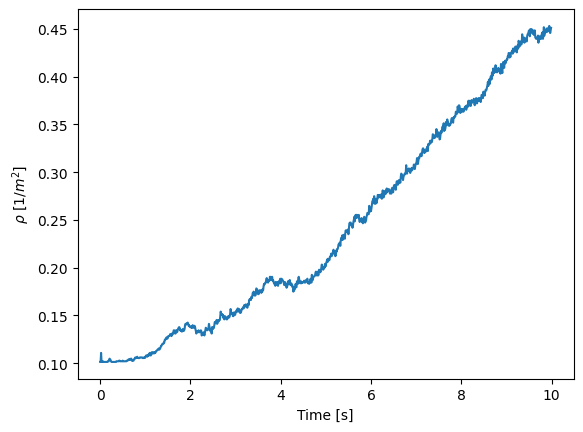

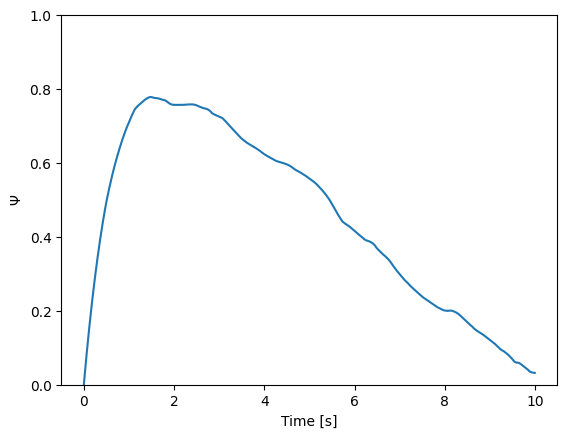

In [8]:
fig = plt.figure()
plt.plot(time_steps * sconst.time_inc, avg_densities)
plt.xlabel("Time [s]")
plt.ylabel(r"$\rho \ [1/m^2]$")

fig = plt.figure()
plt.plot(time_steps[:] * sconst.time_inc, allign_coefs[:])
plt.ylim((0,1))
plt.ylabel(r"$\Psi$")
plt.xlabel("Time [s]")

<IPython.core.display.Javascript object>


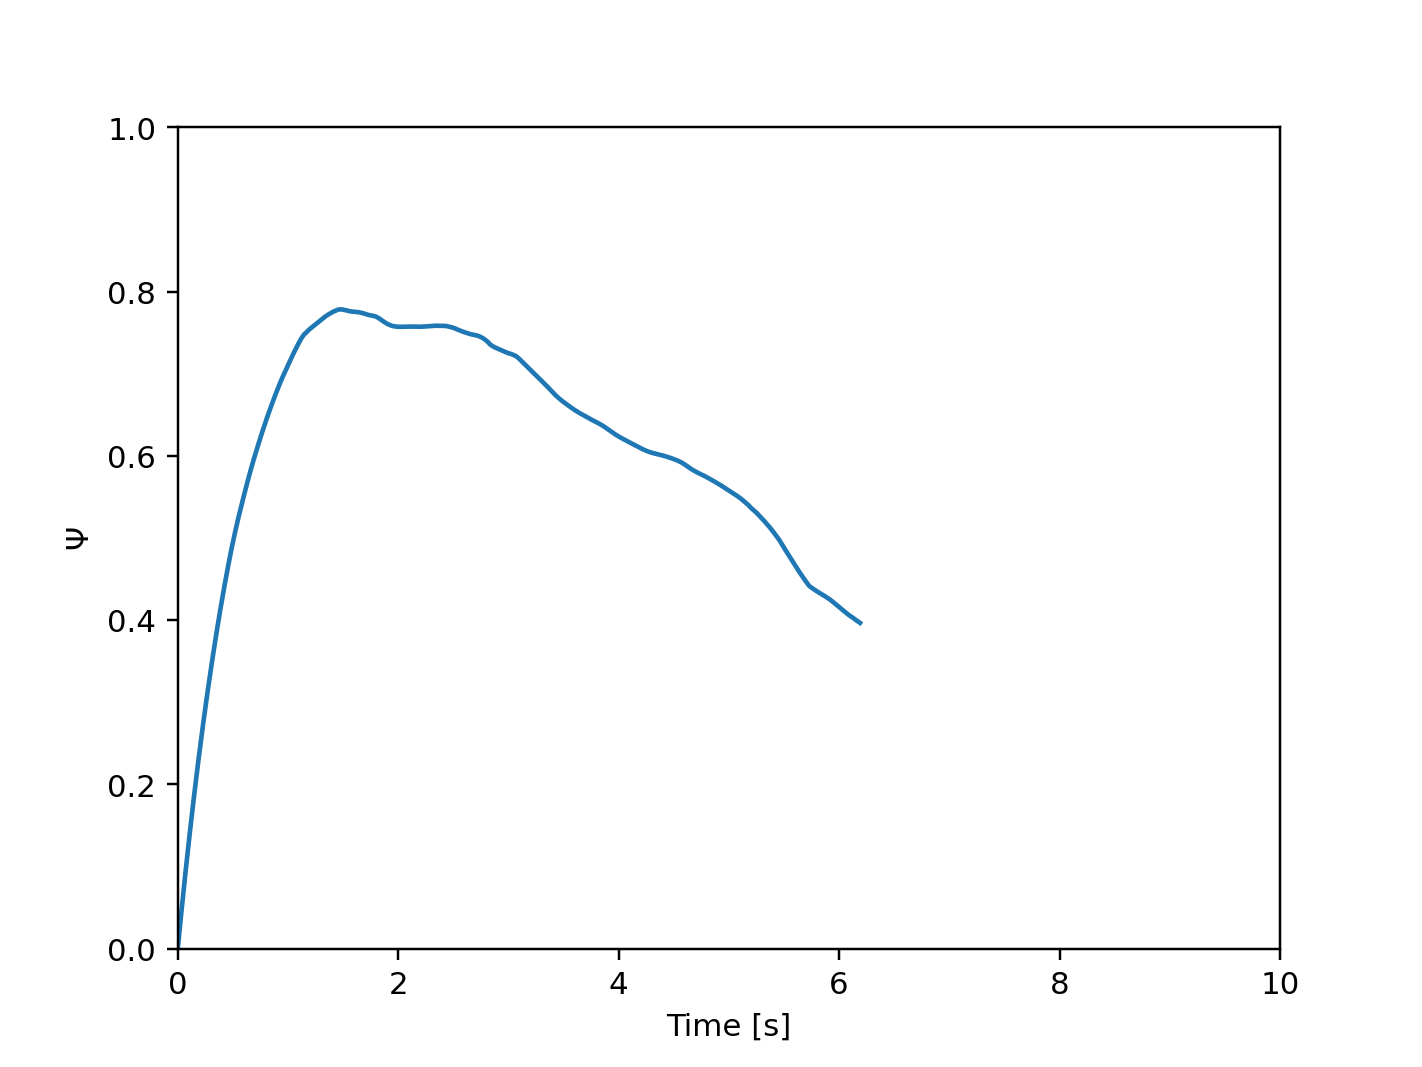

In [9]:
%matplotlib notebook

fig = plt.figure()
xs = []
ys = []
ax = fig.gca()
pt = ax.plot(xs, ys)[0]
ax.set_ylim((0,1))
ax.set_xlim(0, 10)
ax.set_ylabel(r"$\Psi$")
ax.set_xlabel("Time [s]")

def animate_alignment(i_frame, pt):
    i = get_time_step(i_frame, framerate, sconst.time_inc)
    
    pt.set_xdata(time_steps[:i]*sconst.time_inc)
    pt.set_ydata(allign_coefs[:i])

    return pt,

animation_alignment = anim.FuncAnimation(fig=fig, func=animate_alignment, fargs=(pt,),
                                         frames=sconst.simulation_time*framerate, blit=True,
                                         interval=int(1000/framerate))
if save_gifs:
    animation_alignment.save('gifs/alignment_n=300,w=15,v=5.gif', writer=writer)

<IPython.core.display.Javascript object>


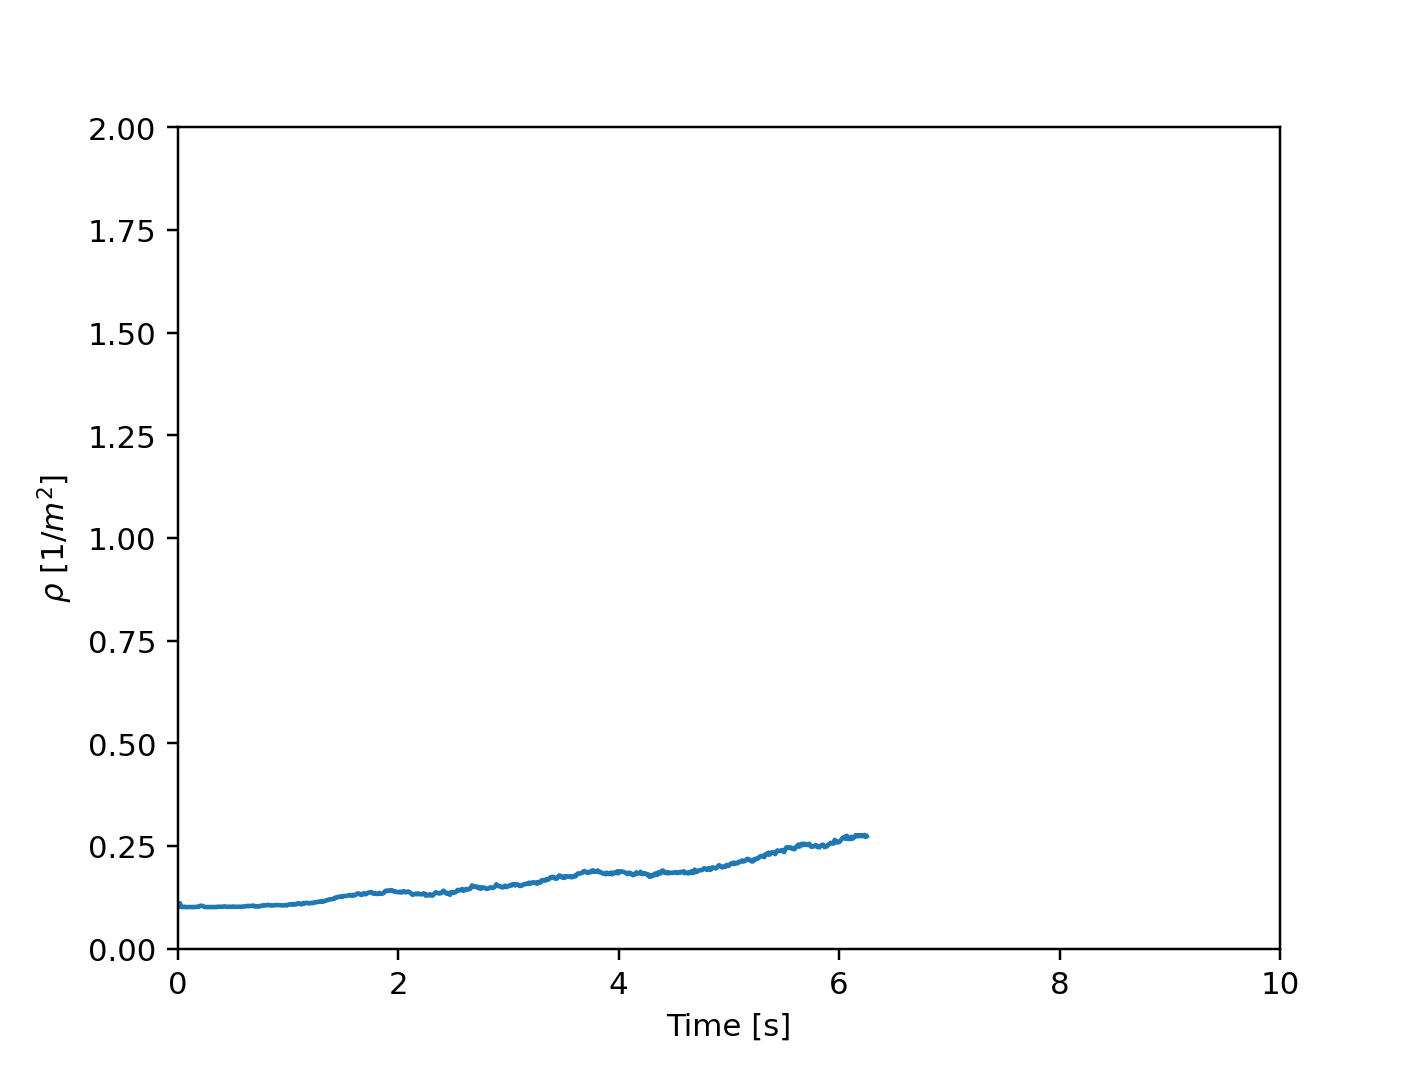

In [10]:
fig = plt.figure()
xs = []
ys = []
ax = fig.gca()
pt = ax.plot(xs, ys)[0]
ax.set_ylim((0,2))
ax.set_xlim(0, 10)
plt.ylabel(r"$\rho \ [1/m^2]$")
ax.set_xlabel("Time [s]")

def animate_density(i_frame, pt):   
    i = get_time_step(i_frame, framerate, sconst.time_inc)
    
    pt.set_xdata(time_steps[:i]*sconst.time_inc)
    pt.set_ydata(avg_densities[:i])

    return pt,

animation_density =anim.FuncAnimation(fig=fig, func=animate_density, fargs=(pt,),
                                         frames=sconst.simulation_time*framerate, blit=True,
                                         interval=int(1000/framerate))
if save_gifs:
    animation_density.save('gifs/density_n=300,w=15,v=5.gif', writer=writer)

In [20]:
def get_n_with_status_t(data, sconst, status):
    living_states = data[:, :, i_ps]
    return np.sum(living_states == status, axis=1)


def animate_status(i_frame, sconst, pt_dead, pt_exited, n_dead, n_exited):
    i = get_time_step(i_frame, framerate, sconst.time_inc)
    
    x = time_steps[:i]*sconst.time_inc
    pt_dead.set_xdata(x)
    pt_exited.set_xdata(x)
    
    pt_dead.set_ydata(n_dead[:i])
    pt_exited.set_ydata(n_exited[:i])
    
    return pt_dead, pt_exited

<IPython.core.display.Javascript object>


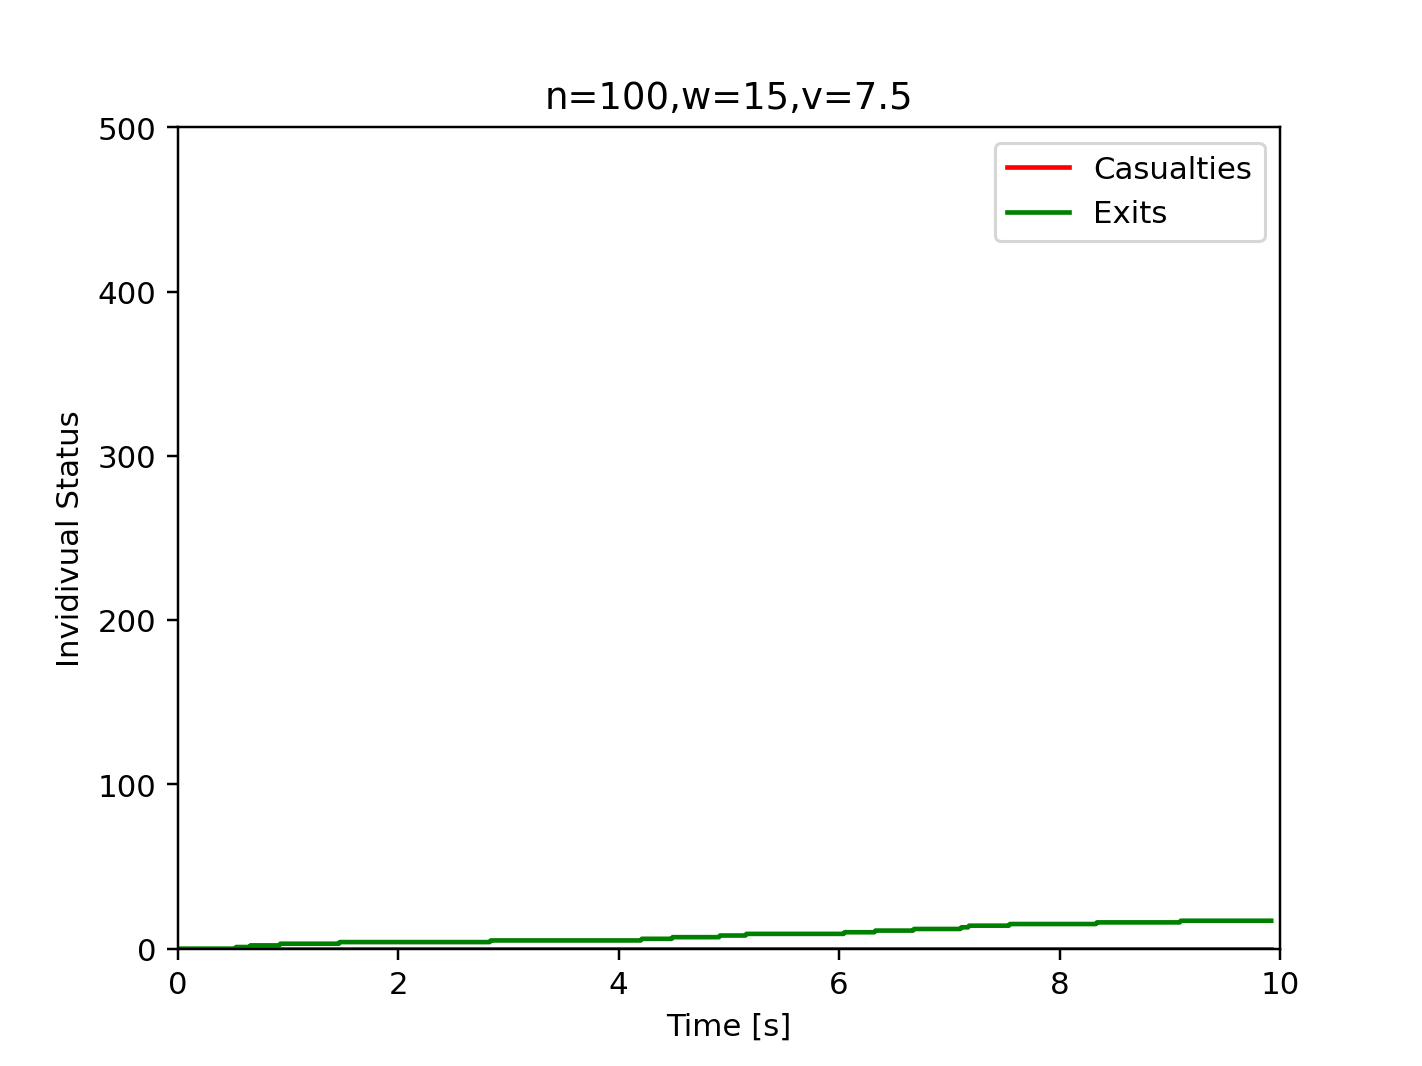

<IPython.core.display.Javascript object>


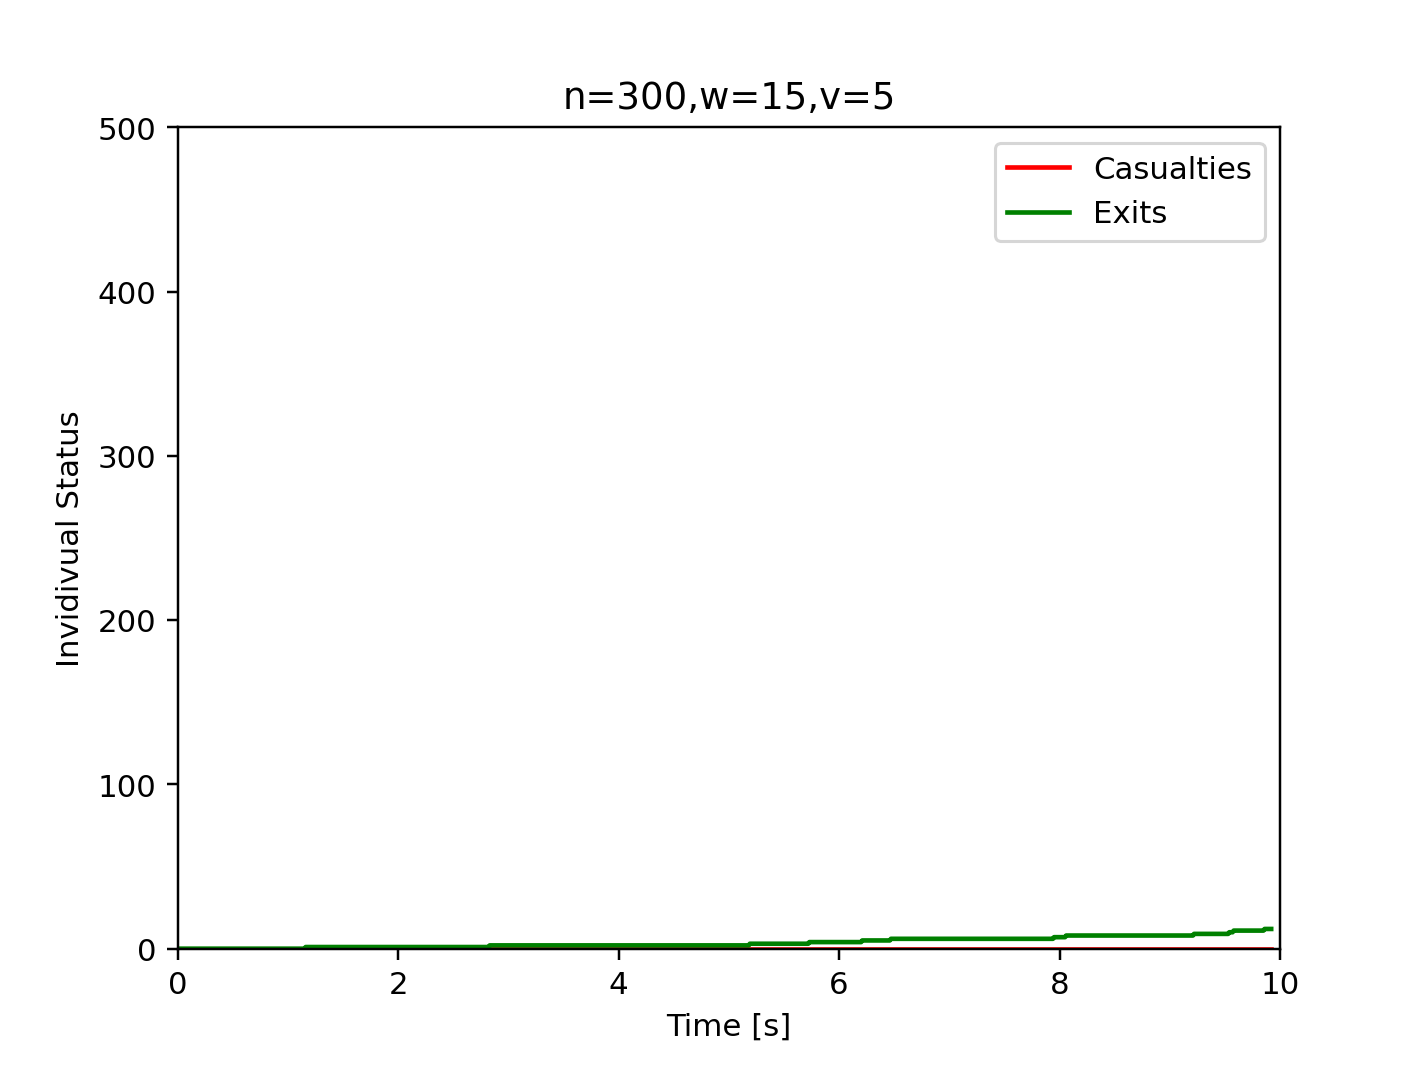

<IPython.core.display.Javascript object>


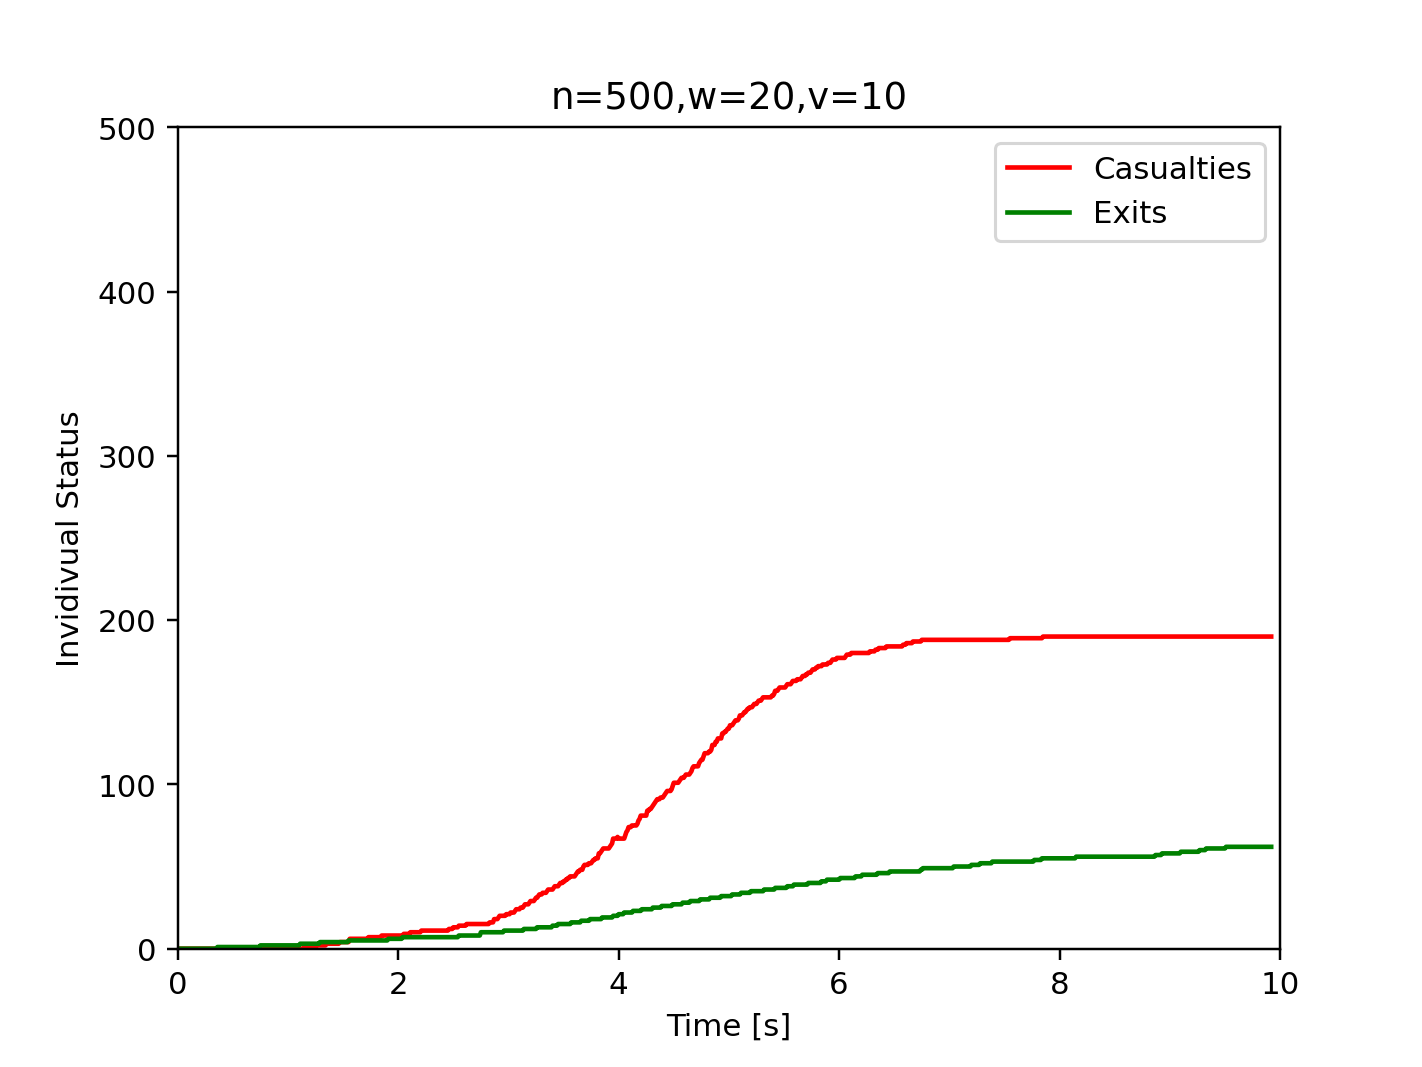

<IPython.core.display.Javascript object>


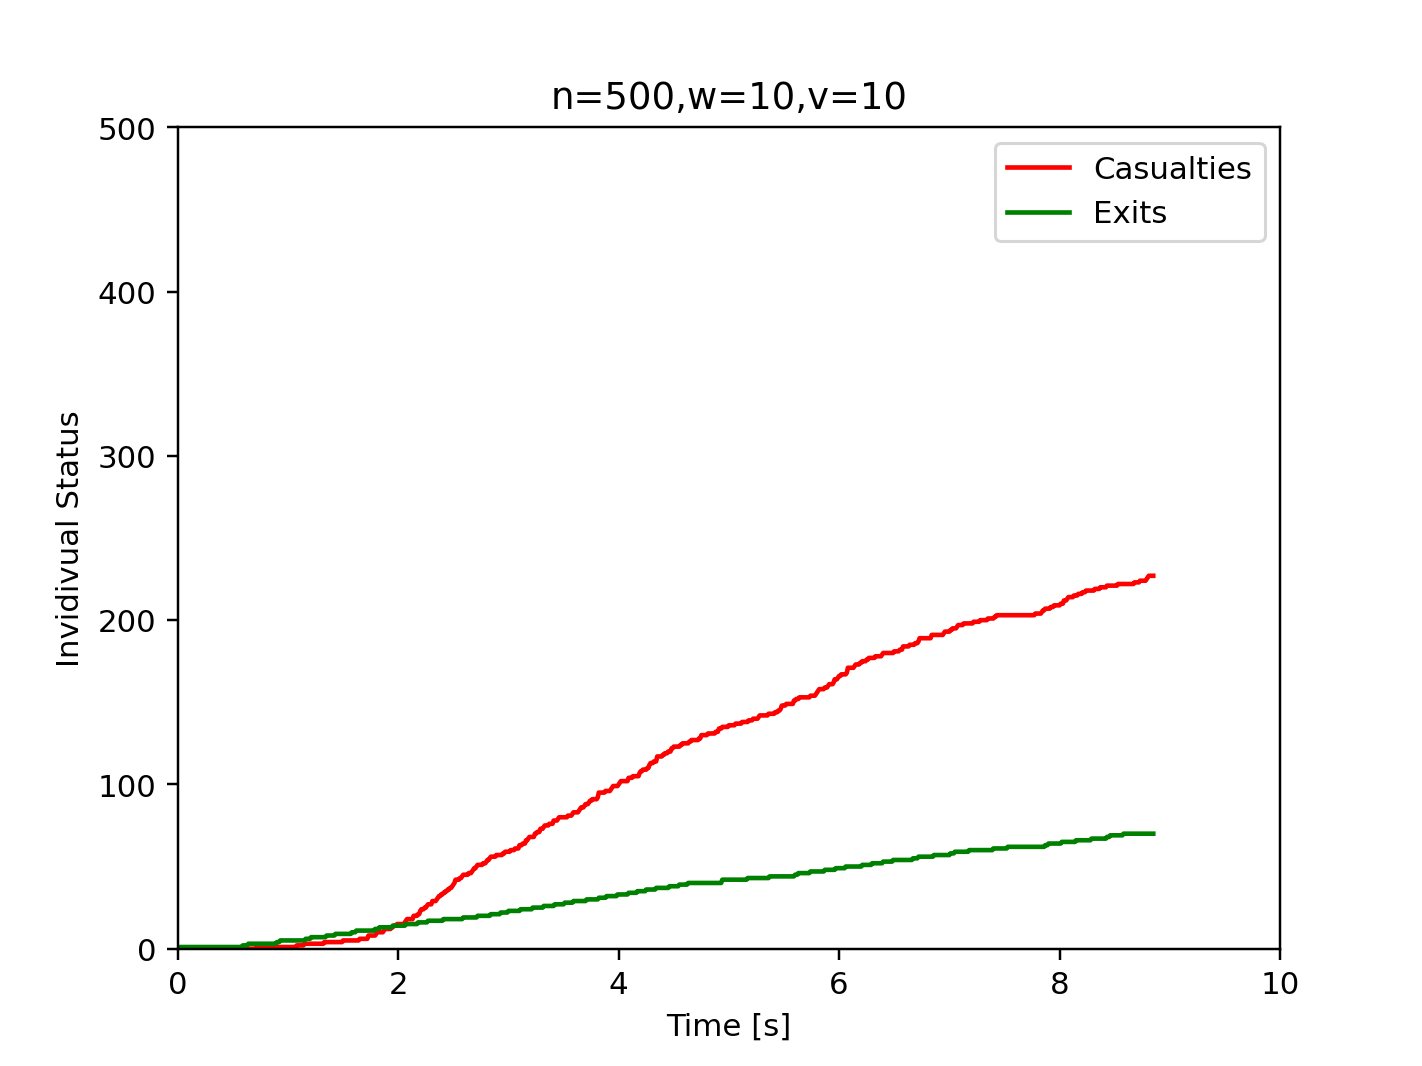

In [26]:
parameters = [
    (100, 15, 7.5), (300, 15, 5),
    (500, 20, 10), (500, 10, 10)
]

for n, w, v in parameters:
    name = f"n={n},w={w},v={v}"
    data, sconst = read_data(name=name)

    n_dead = get_n_with_status_t(data, sconst, sconst.s_dead)
    n_exited = get_n_with_status_t(data, sconst, sconst.s_exited)

    fig = plt.figure()
    ax = fig.gca()

    xs_dead = []
    ys_dead = []
    pt_dead = ax.plot(xs_dead, ys_dead, c='red')[0]

    xs_exited = []
    ys_exited = []
    pt_exited = ax.plot(xs_exited, ys_exited, c='green')[0]

    ax.set_ylim(0, 500)
    ax.set_xlim(0, 10)
    ax.set_ylabel("Invidivual Status")
    ax.set_xlabel("Time [s]")
    ax.legend(["Casualties", "Exits"])
    ax.set_title(name)

    animation_status = anim.FuncAnimation(fig=fig, func=animate_status, fargs=(sconst, pt_dead, pt_exited, n_dead, n_exited),
                                             frames=sconst.simulation_time*framerate, blit=True,
                                             interval=int(1000/framerate))
    if True:
        animation_status.save(f'gifs/status_n={name}.gif', writer=writer)

In [ ]:
%matplotlib inline

def get_n_dead_t(data, sconst):
    living_states = data[-1, :, i_ps]
    n_dead=np.sum(living_states == sconst.s_dead)
    return n_dead


v_list=[5,7.5,10]

death_list1=[]
for v in v_list:
    data, sconst = read_data(name=f"n=500,w=10,v={v}")
    death_list1.append(get_n_dead_t(data, sconst)/500)

death_list2=[]
for v in v_list:
    data, sconst = read_data(name=f"n=300,w=10,v={v}")
    death_list2.append(get_n_dead_t(data, sconst)/300)

death_list3=[]
for v in v_list:
    data, sconst = read_data(name=f"n=200,w=10,v={v}")
    death_list3.append(get_n_dead_t(data, sconst)/200)

death_list4=[]
for v in v_list:
    data, sconst = read_data(name=f"n=100,w=10,v={v}")
    death_list4.append(get_n_dead_t(data, sconst)/100)


plt.figure(figsize=(4,4))
plt.plot(v_list,death_list1,'k-',label='N=500')
plt.plot(v_list,death_list2,'b--',label='N=300')

plt.plot(v_list,death_list3,'r-.',label='N=200')
plt.plot(v_list,death_list4,c='orange',linestyle=':',label='N=100')
plt.ylabel('Casualties / N')
plt.xlabel(r'$v_{d}$ (m/s)')
# plt.ylim(0,300)
plt.xlim(5,10)
plt.legend()
plt.title(r'Fix: $H=10$m')
plt.show()

# wvs = [(10, 5), (10, 10), (20, 5), (20, 10)]
# n_params = len(wvs)

# fig, axes = plt.subplots(n_params, 1, figsize=(5,4*n_params))
# fig.suptitle("Reynold number over initial configurations")
# fig.tight_layout(pad=5)

# for i, (w, v) in enumerate(wvs):
#     ns = (100, 150, 200, 300, 500)
#     death_nums = []

#     for n in ns:
#         data, sconst = read_data(name=f"n={n},w={w},v={5}")
#         # reynold = get_reynold_number(data, sconst)
#         # reynold_nums.append(reynold)
#         death = get_n_dead_t(data, sconst)
#         death_nums.append(death)

#     ax = axes[i]
#     ax.scatter(ns, death_nums)
#     ax.set_title(f"Width = {w} [m], Desired velocity = {v} [m/s^2]")
#     ax.set_xlabel("Number of individuals")
#     ax.set_ylabel("Casualties")

In [ ]:
N_list=[100,200,300,500]

death_list1=[]
for N in N_list:
    data, sconst = read_data(name=f"n={N},w=10,v=5")
    death_list1.append(get_n_dead_t(data, sconst)/N)

death_list2=[]
for N in N_list:
    data, sconst = read_data(name=f"n={N},w=10,v=7.5")
    death_list2.append(get_n_dead_t(data, sconst)/N)

death_list3=[]
for N in N_list:
    data, sconst = read_data(name=f"n={N},w=10,v=10")
    death_list3.append(get_n_dead_t(data, sconst)/N)


plt.figure(figsize=(4,4))
plt.plot(N_list,death_list1,'k-',label='v=5 m/s')
plt.plot(N_list,death_list2,'b--',label='v=7.5 m/s')

plt.plot(N_list,death_list3,'r-.',label='v=10 m/s')
plt.ylabel('Casualties / N')
plt.xlabel(r'$N$')
# plt.ylim(0,300)
plt.xlim(100,500)
plt.legend()
plt.title(r'Fix: $H=10$m')
plt.show()

In [ ]:
H_list=[10,15,20]

death_list1=[]
for H in H_list:
    data, sconst = read_data(name=f"n=500,w={H},v=5")
    death_list1.append(get_n_dead_t(data, sconst)/N)

death_list2=[]
for H in H_list:
    data, sconst = read_data(name=f"n=500,w={H},v=7.5")
    death_list2.append(get_n_dead_t(data, sconst)/N)

death_list3=[]
for H in H_list:
    data, sconst = read_data(name=f"n=500,w={H},v=10")
    death_list3.append(get_n_dead_t(data, sconst)/N)

plt.figure(figsize=(4,4))
plt.plot(H_list,death_list1,'k-',label='v=5 m/s')
plt.plot(H_list,death_list2,'b--',label='v=7.5 m/s')

plt.plot(H_list,death_list3,'r-.',label='v=10 m/s')
plt.ylabel('Casualties / N')
plt.xlabel(r'$H$ (m)')
# plt.ylim(0,300)
plt.xlim(10,20)
plt.legend()
plt.title(r'Fix: $N=500$')
plt.show()